In [1]:
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install tqdm

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
import tensorflow as tf
import keras
import os

# Data visualization

In [3]:
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
# Understand csv file
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

lines = []
csv_path = 'data/driving_log.csv'
with open(csv_path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

images = []
measurements = []
for line in tqdm(lines[1:]):
    filename = line[0]
    image = cv2.imread('data/' + filename)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)


100%|██████████| 8036/8036 [05:19<00:00, 25.15it/s]


### Center, left and right camera images

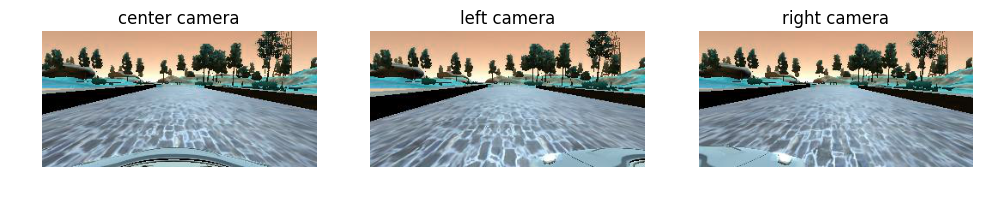

In [53]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(cv2.imread('data/' + lines[1][0]))
plt.title('center camera')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cv2.imread('data/' + lines[1][1].strip()))
plt.title('left camera')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.imread('data/' + lines[1][2].strip()))
plt.title('right camera')
plt.axis('off')
plt.show()

### Steering Angle distribution & histogram

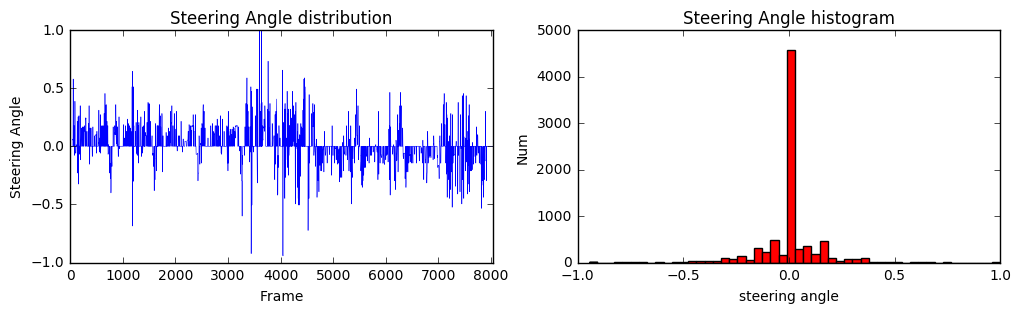

In [62]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
x = [range(len(measurements))]
x = np.squeeze(np.asarray(x))
y = np.asarray(measurements)
plt.xlim(0,len(measurements))
plt.title('Steering Angle distribution')
plt.xlabel('Frame')
plt.ylabel('Steering Angle')
plt.plot(x,y, 'b', linewidth=0.5)
plt.subplot(1,2,2)
plt.hist(measurements, bins= 50, color= 'red')
plt.title('Steering Angle histogram')
plt.xlabel('steering angle')
plt.ylabel('Num')
plt.show()

(-0.5, 319.5, 79.5, -0.5)

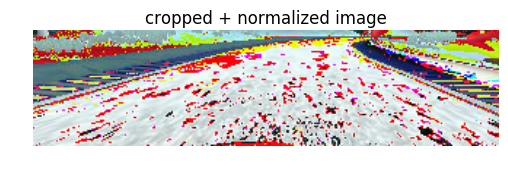

In [44]:
plt.imshow(images[1100][60:140] / 255.0 - 0.5)
plt.title('cropped + normalized image')
plt.axis('off')

# Model Training

### Basic model training

In [67]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save('model.h5')

Train on 6428 samples, validate on 1608 samples
Epoch 1/10
6428/6428 [==============================] - 49s - loss: 8322748.0646 - val_loss: 5882.7960

### Basic model training + generator

In [16]:
import os
import csv

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Cropping2D
from keras.layers import Convolution2D, MaxPooling2D

lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
      

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines[1:], test_size=0.2)

import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for line in batch_samples:
                filename = line[0]
                image = cv2.imread('data/' + filename)
                images.append(image)
                angle = float(line[3])
                angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x / 255.0 - 0.5,
        input_shape=(row, col, ch)))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.fit_generator(train_generator, 
                    samples_per_epoch=len(train_samples),
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), 
                    nb_epoch=3)

Epoch 1/3
6428/6428 [==============================] - 19s - loss: 2.1767 - val_loss: 1.5523

# Data Augmentation

(-0.5, 319.5, 159.5, -0.5)

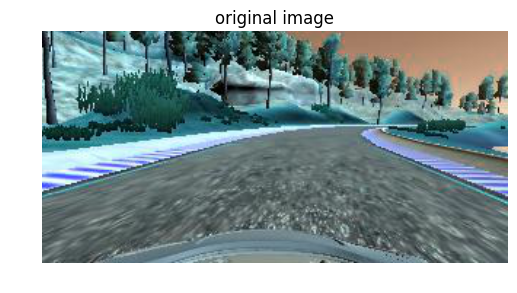

In [42]:
plt.imshow(images[1100])
plt.title('original image')
plt.axis('off')

### Image transformations

In [27]:
def image_flipping(image, steering=0):
    """
    Flip image to fix track left turn biasing
    """
    new_image, new_steering = cv2.flip(image, 1), -1.0 * steering
    return new_image, new_steering

def image_brightness(image, steering=0):
    """
    Randomly change image brightness
    """
    new_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_brightness = 0.2 + np.random.uniform(0.2, 0.6)
    new_image[:, :, 2] = new_image[:, :, 2] * random_brightness
    new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    return new_image, steering

def image_shifting(image, steering=0):
    """
    Randomly shift image on the X axis
    """
    max_shift = 55
    max_ang = 0.14  # ang_per_pixel = 0.0025

    rows, cols, _ = image.shape

    random_x = np.random.randint(-max_shift, max_shift + 1)
    new_steering = steering + (random_x / max_shift) * max_ang
    if abs(new_steering) > 1:
        new_steering = -1 if (new_steering < 0) else 1

    mat = np.float32([[1, 0, random_x], [0, 1, 0]])
    new_image = cv2.warpAffine(image, mat, (cols, rows))
    return new_image, new_steering

def image_shadow(self, image):
    """
    Generate shadow in random region of the image
    """
    top_x, bottom_x = np.random.randint(0, 160, 2)
    rows, cols, _ = image.shape
    new_image = image.copy()
    mask = image.copy()

    vertices = np.array([[(50, 65), (45, 0), (145, 0), (150, 65)]], dtype=np.int32)
    if np.random.randint(2):
        vertices = np.array([[top_x, 0], [cols, 0], [cols, rows], [bottom_x, rows]], dtype=np.int32)
    else:
        vertices = np.array([[top_x, 0], [0, 0], [0, rows], [bottom_x, rows]], dtype=np.int32)

    cv2.fillPoly(mask, [vertices], (0,) * image.shape[2])
    rand_a = np.random.uniform(0.5, 0.75)
    cv2.addWeighted(mask, rand_a, image, 1 - rand_a, 0., new_image)

    return new_image

In [34]:
flip_img, flip_steering = image_flipping(images[1100])
shift_img, shift_steering = image_shifting(images[1100])
darken_img, _ = image_brightness(images[1100])
shadow_image = image_shadow(images[1100])

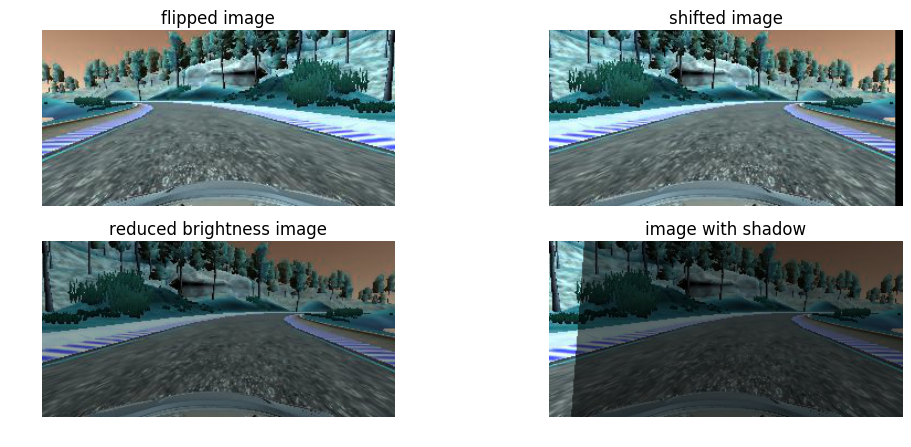

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.imshow(flip_img)
plt.title('flipped image')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(shift_img)
plt.title('shifted image')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(darken_img)
plt.title('reduced brightness image')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(shadow_image)
plt.title('image with shadow')
plt.axis('off')
plt.show()

### Image cropping

(-0.5, 319.5, 79.5, -0.5)

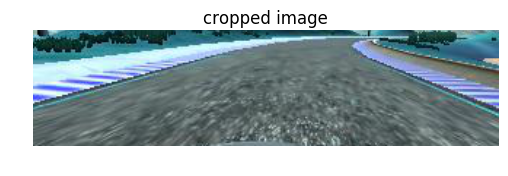

In [66]:
plt.imshow(images[1100][60:140])
plt.title('cropped image')
plt.axis('off')